In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import random

# Set random seed
seed = 42
np.random.seed(seed)          # For NumPy operations
random.seed(seed)             # For Python's built-in random module
tf.random.set_seed(seed)      # For TensorFlow operations

In [3]:
#df = pd.read_csv('/content/drive/My Drive/Project/data/GOOG-year.csv')
from google.colab import files
uploaded = files.upload()

Saving google.csv to google.csv


In [55]:
df = pd.read_csv('google.csv')
df.shape

(252, 6)

In [56]:
df.rename(columns={'Close/Last': 'Close'}, inplace=True)
df["Close"] = df["Close"].str.replace('$', '', regex=False).astype(float)
df["Close"] = df["Close"].astype(int)
df["Close"].isna().any()

False

In [57]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [7]:
df.head()

,Date,Close,Volume,Open,High,Low
251,2023-12-07,138,38419430,$136.60,$140.00,$136.23
250,2023-12-08,136,23016140,$135.66,$137.99,$135.57
249,2023-12-11,134,24502860,$133.82,$134.79,$132.89
248,2023-12-12,133,26583980,$133.27,$134.54,$132.83
247,2023-12-13,133,25414460,$134.545,$134.78,$132.95


In [8]:
df.tail()

,Date,Close,Volume,Open,High,Low
4,2024-12-02,172,16593440,$170.32,$173.60,$170.27
3,2024-12-03,173,15721480,$173.12,$174.32,$172.51
2,2024-12-04,176,18239840,$172.78,$176.43,$172.75
1,2024-12-05,174,16145520,$177.32,$177.71,$174.01
0,2024-12-06,176,13319550,$173.88,$176.8389,$173.55


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import random

class DQNState:
    def __init__(self, trend, initial_cash=10000, window_size=30):
        self.trend = trend
        self.initial_cash = initial_cash
        self.window_size = window_size
        self.state_size = self.window_size + 4
        self.reset()

    def reset(self):
        self.cash_balance = self.initial_cash
        self.stock_balance = 0
        self.current_step = 0
        self.portfolio = [self.initial_cash]
        return self.get_state()

    def get_state(self):
        """
        Generate a flat state representation for DQN-based models with feature normalization.
        """
        window_size = self.window_size + 1
        d = self.current_step - window_size + 1
        block = (
            self.trend[d: self.current_step + 1]
            if d >= 0
            else -d * [self.trend[0]] + self.trend[0: self.current_step + 1]
        )
        price_diff = [block[i + 1] - block[i] for i in range(len(block) - 1)]
        price_diff = [0] * (self.window_size - len(price_diff)) + price_diff  # Padding

        # Normalize features
        current_trend = self.trend[self.current_step]  # Already normalized by its scale
        mean_trend = np.mean(self.trend[: self.current_step + 1])  # Already normalized by its scale

        # Create state with normalized features
        state = [
            self.cash_balance ,
            self.stock_balance,
            current_trend,
            mean_trend,
        ]
        state.extend(price_diff)
        return np.array(state, dtype=np.float32)



    def get_state_techical(self):
        """
        Generate a flat state representation for DQN-based models with added technical indicators.
        """
        window_size = self.window_size + 1
        d = self.current_step - window_size + 1
        block = (
            self.trend[d: self.current_step + 1]
            if d >= 0
            else -d * [self.trend[0]] + self.trend[0: self.current_step + 1]
        )
        price_diff = [block[i + 1] - block[i] for i in range(len(block) - 1)]
        price_diff = [0] * (self.window_size - len(price_diff)) + price_diff

        # Calculate technical indicators
        if self.current_step >= 1:
            close_prices = np.array(self.trend[:self.current_step + 1])

            # Moving averages
            ma_short = np.mean(close_prices[-5:]) if len(close_prices) >= 5 else np.mean(close_prices)
            ma_long = np.mean(close_prices[-20:]) if len(close_prices) >= 20 else np.mean(close_prices)

            # Relative Strength Index (RSI)
            deltas = np.diff(close_prices)
            gains = deltas[deltas > 0].sum() if len(deltas) > 0 else 0
            losses = -deltas[deltas < 0].sum() if len(deltas) > 0 else 0
            avg_gain = gains / 14 if len(close_prices) >= 14 else gains
            avg_loss = losses / 14 if len(close_prices) >= 14 else losses
            rs = avg_gain / avg_loss if avg_loss > 0 else 0
            rsi = 100 - (100 / (1 + rs)) if avg_loss > 0 else 100

            # Bollinger Bands
            rolling_std = np.std(close_prices[-20:]) if len(close_prices) >= 20 else 0
            bb_upper = ma_long + 2 * rolling_std
            bb_lower = ma_long - 2 * rolling_std
        else:
            ma_short, ma_long, rsi, bb_upper, bb_lower = 0, 0, 0, 0, 0

        # State includes technical indicators
        state = [
            self.cash_balance,
            self.stock_balance,
            self.trend[self.current_step],
            np.mean(self.trend[: self.current_step + 1]),
            ma_short,
            ma_long,
            rsi,
            bb_upper,
            bb_lower,
        ]
        state.extend(price_diff)
        return np.array(state, dtype=np.float32)


    def step(self, action):
        current_price = self.trend[self.current_step]
        portfolio_value_before = self.cash_balance + (self.stock_balance * current_price)

        # Apply actions
        if action == 1:  # Buy (allow buying on credit)
            self.stock_balance += 1
            self.cash_balance -= current_price  # Cash balance can go negative

        elif action == 2:  # Sell (allow short selling)
            self.stock_balance -= 1  # Stock balance can go negative
            self.cash_balance += current_price

        # Update portfolio value
        portfolio_value = self.cash_balance + (self.stock_balance * current_price)

        # Reward calculation
        if self.current_step > 0:
            reward = np.log(portfolio_value / self.portfolio[-1])
        else:
            reward = 0

        # Amplify reward for stronger signals (optional)
        reward *= 10

        # Update portfolio and step
        self.portfolio.append(portfolio_value)
        self.current_step += 1

        # Logging for debugging
        #print(
        #    f"Step {self.current_step}: Action: {action}, "
        #    f"Price: {current_price:.2f}, Portfolio Before: {portfolio_value_before:.2f}, "
        #    f"Portfolio After: {portfolio_value:.2f}, Reward: {reward:.4f}, "
        #    f"Cash Balance: {self.cash_balance:.2f}, Stock Balance: {self.stock_balance}"
        #)

        # Check if done
        done = self.current_step >= len(self.trend) - 1
        return (None if done else self.get_state()), reward, done




In [60]:
from collections import deque
import random

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        if next_state is None:
            next_state = np.zeros_like(state, dtype=np.float32)
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = np.array([np.array(e[0], dtype=np.float32) for e in experiences])
        actions = np.array([e[1] for e in experiences], dtype=np.int32)
        rewards = np.array([e[2] for e in experiences], dtype=np.float32)
        next_states = np.array([np.array(e[3], dtype=np.float32) for e in experiences])
        dones = np.array([e[4] for e in experiences], dtype=np.float32)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


In [61]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

class Agent:
    def __init__(self, state_size, action_size=3, buffer_size=10000, batch_size=64, tau=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.tau = tau

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Q-Networks
        self.model = self._build_model()
        self.target_model = clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())

    def _build_model(self):
        model = Sequential([
            Dense(256, activation='relu', input_dim=self.state_size),
            Dense(256, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = np.expand_dims(state, axis=0)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample()
        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        self.model.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def soft_update_target_model(self):
        target_weights = self.target_model.get_weights()
        policy_weights = self.model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * policy_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def train(self, state_env, episodes, update_every=4):
        """Trains the agent using the environment."""
        for episode in range(episodes):
            state = state_env.reset()
            total_reward = 0
            done = False
            step = 0

            print(f"Episode {episode + 1}/{episodes} starting...")

            while not done:
                action = self.act(state)
                next_state, reward, done = state_env.step(action)
                self.memory.add(state, action, reward, next_state, done)

                # Log action and environment state
                current_price = state_env.trend[state_env.current_step - 1]  # Trend at current step
                portfolio_value = state_env.cash_balance + (state_env.stock_balance * current_price)
                #print(f"Step {step + 1}: Action: {action}, Price: {current_price}, Portfolio: {portfolio_value:.2f}, Reward: {reward:.4f}")

                state = next_state
                total_reward += reward
                step += 1

                # Train the network every `update_every` steps
                if step % update_every == 0:
                    self.replay()

                # Soft update the target network
                self.soft_update_target_model()

            print(f"Episode {episode + 1}/{episodes} completed. Total Reward: {total_reward:.2f}")


    def buy(self, state_env):
        state = state_env.reset()
        states_buy, states_sell = [], []

        while state_env.current_step < len(state_env.trend) - 1:
            action = self.act(state)

            # Track actions for logging purposes
            if action == 1:  # Buy (even if cash_balance < trend price)
                states_buy.append(state_env.current_step)
            elif action == 2:  # Sell (even if stock_balance < 0)
                states_sell.append(state_env.current_step)

            state, _, done = state_env.step(action)
            if done:
                break

        # Calculate total gains and investment return
        total_gains = state_env.cash_balance - state_env.initial_cash
        invest = (total_gains / state_env.initial_cash) * 100
        return states_buy, states_sell, total_gains, invest

In [95]:
# Data preparation
close = df['Close'].values.tolist()

# Split into training and testing data
train_size = int(len(close) * 0.8)
train_trend = close[:train_size]
test_trend = close[train_size:]

# Hyperparameters
initial_money = 10000
window_size = 30
episodes = 3

# Set up the training environment
state_env = DQNState(trend=train_trend, initial_cash=initial_money, window_size=window_size)
state_size = state_env.state_size

# Create the agent
agent = Agent(state_size=state_size, action_size=3, buffer_size=10000, batch_size=64)

# Train the agent
print("Starting Training...")
agent.train(state_env=state_env, episodes=episodes)

Starting Training...
Episode 1/3 starting...
Episode 1/3 completed. Total Reward: -0.20
Episode 2/3 starting...
Episode 2/3 completed. Total Reward: 0.64
Episode 3/3 starting...
Episode 3/3 completed. Total Reward: 0.75



Starting Testing...

Testing Results:
Total Gains: $4001.00
Investment Return: 40.01%


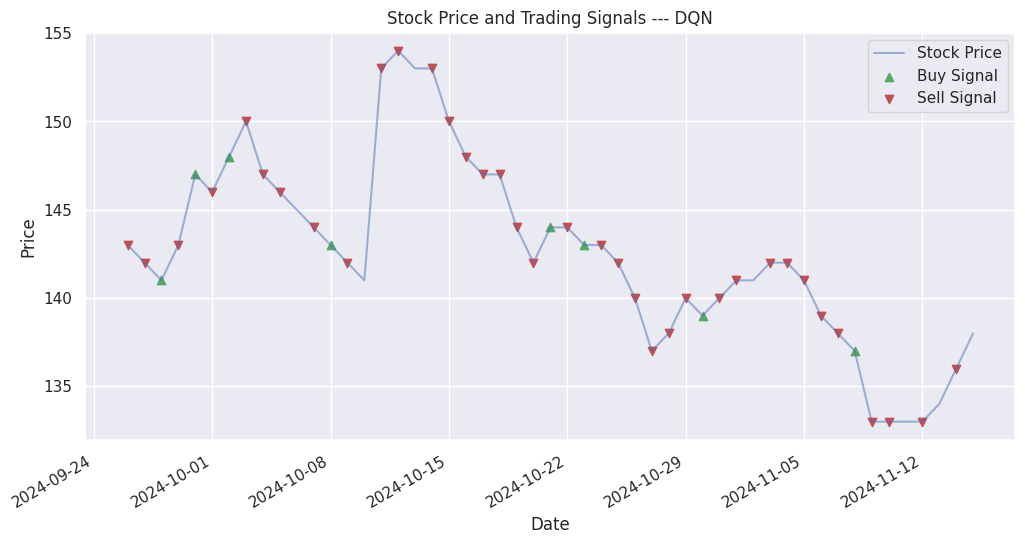

In [110]:
import matplotlib.dates as mdates

start_date = pd.Timestamp('2024-09-26')
# Set up the testing environment
state_env_test = DQNState(trend=test_trend, initial_cash=initial_money, window_size=window_size)

# Test the agent
print("\nStarting Testing...")
states_buy, states_sell, total_gains, invest = agent.buy(state_env=state_env_test)

# Print testing results
print("\nTesting Results:")
print(f"Total Gains: ${total_gains:.2f}")
print(f"Investment Return: {invest:.2f}%")

# Generate date range from start_date for test_trend
dates = pd.date_range(start=start_date, periods=len(test_trend))

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(dates, test_trend, label="Stock Price", alpha=0.5)
plt.scatter([dates[i] for i in states_buy], [test_trend[i] for i in states_buy], marker="^", color="g", label="Buy Signal", alpha=1)
plt.scatter([dates[i] for i in states_sell], [test_trend[i] for i in states_sell], marker="v", color="r", label="Sell Signal", alpha=1)
plt.title("Stock Price and Trading Signals --- DQN")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Format x-axis for dates with more frequent ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Adjust interval for tick frequency
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


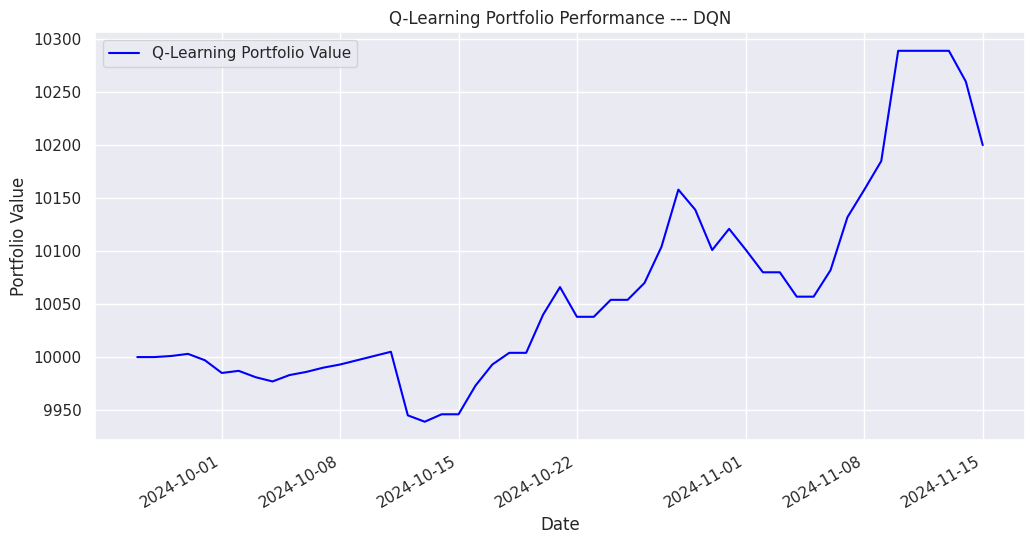

In [118]:
# Testing the DQN agent
dqn_portfolio = [state_env_test.initial_cash]  # Initialize portfolio values
state_env_test.reset()

# Generate dates for the x-axis
dates = pd.date_range(start=start_date, periods=len(test_trend))

# Perform testing and collect DQN portfolio over time
for i in range(len(test_trend) - 1):
    state = state_env_test.get_state()
    action = agent.act(state)
    next_state, _, done = state_env_test.step(action)
    current_portfolio_value = state_env_test.cash_balance + (state_env_test.stock_balance * test_trend[i])
    dqn_portfolio.append(current_portfolio_value)
    if done:
        break

# Plot the portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(dqn_portfolio)], dqn_portfolio, label="Q-Learning Portfolio Value", color="blue")
plt.title("Q-Learning Portfolio Performance --- DQN")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()


In [123]:
def benchmark_buy_and_hold(trend, initial_cash=10000):
    buy_price = trend[0]
    final_price = trend[-1]
    num_stocks = initial_cash // buy_price
    final_portfolio_value = num_stocks * final_price
    total_gains = final_portfolio_value - initial_cash
    return total_gains, (total_gains / initial_cash) * 100
def benchmark_moving_average(trend, short_window=5, long_window=20, initial_cash=10000):
    """
    Simulates a moving average crossover strategy.

    Args:
        trend (list): List of stock prices.
        short_window (int): Window size for the short-term moving average.
        long_window (int): Window size for the long-term moving average.
        initial_cash (float): Starting cash for the portfolio.

    Returns:
        total_gains (float): Total portfolio gains.
        return_percentage (float): Percentage return on initial cash.
        portfolio_values (list): Portfolio value over time.
    """
    short_ma = pd.Series(trend).rolling(window=short_window).mean()
    long_ma = pd.Series(trend).rolling(window=long_window).mean()

    cash_balance = initial_cash
    stock_balance = 0
    portfolio_values = []

    for i in range(len(trend)):
        if i >= long_window:  # Only consider signals after sufficient data
            if short_ma[i] > long_ma[i] and cash_balance >= trend[i]:  # Buy
                num_stocks = cash_balance // trend[i]
                cash_balance -= num_stocks * trend[i]
                stock_balance += num_stocks
            elif short_ma[i] < long_ma[i] and stock_balance > 0:  # Sell
                cash_balance += stock_balance * trend[i]
                stock_balance = 0

        # Calculate portfolio value
        portfolio_value = cash_balance + stock_balance * trend[i]
        portfolio_values.append(portfolio_value)

    final_portfolio_value = cash_balance + stock_balance * trend[-1]
    total_gains = final_portfolio_value - initial_cash
    return total_gains, (total_gains / initial_cash) * 100, portfolio_values

def benchmark_recent_trend_strategy(prices, initial_cash):
    """
    Simulates a trading strategy based on recent price movement (buy on rise, sell on fall).

    Args:
        prices (list): List of stock prices.
        initial_cash (float): Starting cash for the portfolio.

    Returns:
        gains (float): Total portfolio value at the end.
        returns (float): Percentage return on initial investment.
        portfolio_values (list): Portfolio value over time.
    """
    cash_balance = initial_cash
    stock_balance = 0
    portfolio_values = [initial_cash]  # Include initial cash as the starting portfolio value

    for i in range(1, len(prices)):
        if prices[i] > prices[i - 1]:  # Price rise, buy
            num_stocks = cash_balance // prices[i]
            cash_balance -= num_stocks * prices[i]
            stock_balance += num_stocks
        elif prices[i] < prices[i - 1]:  # Price drop, sell
            cash_balance += stock_balance * prices[i]
            stock_balance = 0

        # Calculate portfolio value
        portfolio_value = cash_balance + stock_balance * prices[i]
        portfolio_values.append(portfolio_value)

    final_portfolio_value = cash_balance + stock_balance * prices[-1]
    return final_portfolio_value - initial_cash, (final_portfolio_value / initial_cash - 1) * 100, portfolio_values




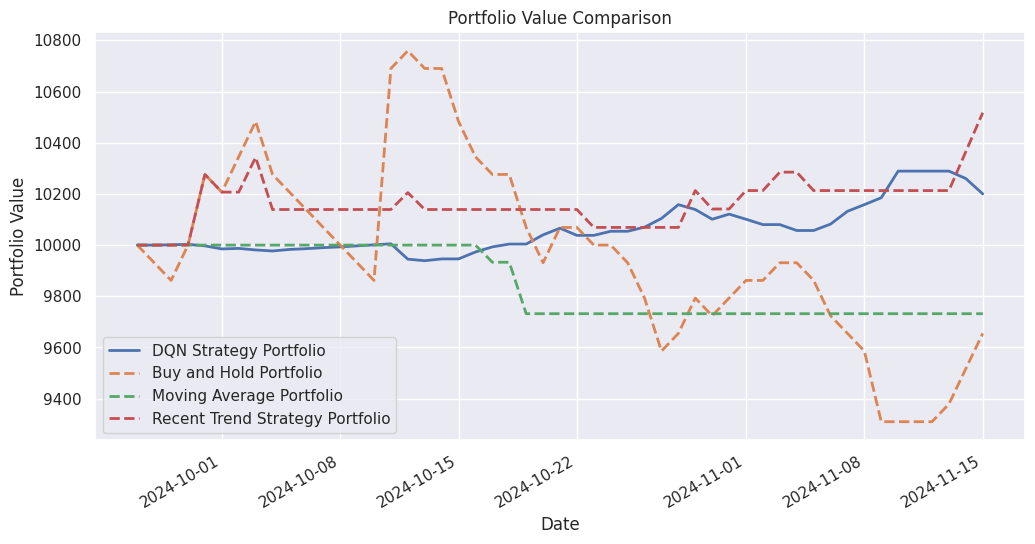


Portfolio Performance Results:
DQN Strategy: Total Gains = $200.00, Return = 2.00%
Buy and Hold: Total Gains = $-478.00, Return = -4.78%
Moving Average: Total Gains = $-268.00, Return = -2.68%
Recent Trend Strategy: Total Gains = $517.00, Return = 5.17%


In [125]:
# Calculate benchmarks
initial_money = 10000

# Buy and Hold
bh_gains, bh_return = benchmark_buy_and_hold(test_trend, initial_cash=initial_money)
bh_portfolio_values = [initial_money + (initial_money // test_trend[0]) * (price - test_trend[0]) for price in test_trend]

# Moving Average
ma_gains, ma_return, ma_portfolio_values = benchmark_moving_average(test_trend, initial_cash=initial_money)

# Recent Trend Strategy
rt_gains, rt_return, rt_portfolio_values = benchmark_recent_trend_strategy(test_trend, initial_cash=initial_money)

# DQN Strategy Results
dqn_total_gains = dqn_portfolio[-1] - dqn_portfolio[0]
dqn_return = (dqn_portfolio[-1] / dqn_portfolio[0] - 1) * 100

# Plot all portfolio values
plt.figure(figsize=(12, 6))

# Plot DQN portfolio values
plt.plot(dates[:len(dqn_portfolio)], dqn_portfolio, label="DQN Strategy Portfolio", linewidth=2)

# Plot benchmarks
plt.plot(dates, bh_portfolio_values, label="Buy and Hold Portfolio", linestyle="--", linewidth=2)
plt.plot(dates, ma_portfolio_values, label="Moving Average Portfolio", linestyle="--", linewidth=2)
plt.plot(dates, rt_portfolio_values, label="Recent Trend Strategy Portfolio", linestyle="--", linewidth=2)

# Add labels and legend
plt.title("Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

# Print all results
print("\nPortfolio Performance Results:")
print(f"DQN Strategy: Total Gains = ${dqn_total_gains:.2f}, Return = {dqn_return:.2f}%")
print(f"Buy and Hold: Total Gains = ${bh_gains:.2f}, Return = {bh_return:.2f}%")
print(f"Moving Average: Total Gains = ${ma_gains:.2f}, Return = {ma_return:.2f}%")
print(f"Recent Trend Strategy: Total Gains = ${rt_gains:.2f}, Return = {rt_return:.2f}%")




In [115]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size=3, buffer_size=10000, batch_size=64, tau=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.tau = tau

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Double Q-Networks
        self.model_a = self._build_model()
        self.model_b = self._build_model()
        self.target_model_a = clone_model(self.model_a)
        self.target_model_b = clone_model(self.model_b)
        self.target_model_a.set_weights(self.model_a.get_weights())
        self.target_model_b.set_weights(self.model_b.get_weights())

        # Alternation flag for updates
        self.use_model_a = True

    def _build_model(self):
        model = Sequential([
            Dense(256, activation='relu', input_dim=self.state_size),
            Dense(256, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = np.expand_dims(state, axis=0)
        if self.use_model_a:
            q_values = self.model_a.predict(state, verbose=0)
        else:
            q_values = self.model_b.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample()

        # Use alternation for target calculation
        if self.use_model_a:
            q_values_next = self.model_a.predict(next_states, verbose=0)
            target_q_values = self.target_model_b.predict(next_states, verbose=0)
        else:
            q_values_next = self.model_b.predict(next_states, verbose=0)
            target_q_values = self.target_model_a.predict(next_states, verbose=0)

        # Compute target values
        targets = np.zeros_like(q_values_next)
        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                best_action = np.argmax(q_values_next[i])
                targets[i, actions[i]] = rewards[i] + self.gamma * target_q_values[i, best_action]

        # Train the active model
        if self.use_model_a:
            self.model_a.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)
        else:
            self.model_b.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Alternate between models
        self.use_model_a = not self.use_model_a

    def soft_update_target_models(self):
        # Update target networks with soft updates
        for target, model in [(self.target_model_a, self.model_a), (self.target_model_b, self.model_b)]:
            target_weights = target.get_weights()
            model_weights = model.get_weights()
            for i in range(len(target_weights)):
                target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
            target.set_weights(target_weights)

    def train(self, state_env, episodes, update_every=4):
        """Trains the agent using the environment."""
        for episode in range(episodes):
            state = state_env.reset()
            total_reward = 0
            done = False
            step = 0

            print(f"Episode {episode + 1}/{episodes} starting...")

            while not done:
                action = self.act(state)
                next_state, reward, done = state_env.step(action)
                self.memory.add(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward
                step += 1

                if step % update_every == 0:
                    self.replay()
                    self.soft_update_target_models()

            print(f"Episode {episode + 1}/{episodes} completed. Total Reward: {total_reward:.2f}")

    def buy(self, state_env):
        state = state_env.reset()
        states_buy, states_sell = [], []

        while state_env.current_step < len(state_env.trend) - 1:
            action = self.act(state)

            if action == 1:  # Buy
                states_buy.append(state_env.current_step)
            elif action == 2:  # Sell
                states_sell.append(state_env.current_step)

            state, _, done = state_env.step(action)
            if done:
                break

        total_gains = state_env.cash_balance - state_env.initial_cash
        invest = (total_gains / state_env.initial_cash) * 100
        return states_buy, states_sell, total_gains, invest




In [128]:
# Data preparation
close = df['Close'].values.tolist()

# Split into training and testing data
train_size = int(len(close) * 0.8)
train_trend = close[:train_size]
test_trend = close[train_size:]

# Hyperparameters
initial_money = 10000
window_size = 30
episodes = 5
update_every = 4

# Set up the training environment
state_env_train = DQNState(trend=train_trend, initial_cash=initial_money, window_size=window_size)
state_size = state_env_train.state_size

# Create the Double Q-Learning agent
double_dqn_agent = DoubleDQNAgent(
    state_size=state_size,
    action_size=3,  # Actions: Hold, Buy, Sell
    buffer_size=10000,
    batch_size=64,
    tau=0.1,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
)

# Train the agent
print("Starting Training...")
double_dqn_agent.train(state_env=state_env_train, episodes=episodes, update_every=update_every)


Starting Training...
Episode 1/5 starting...
Episode 1/5 completed. Total Reward: 0.10
Episode 2/5 starting...
Episode 2/5 completed. Total Reward: 0.30
Episode 3/5 starting...
Episode 3/5 completed. Total Reward: -0.47
Episode 4/5 starting...
Episode 4/5 completed. Total Reward: -0.46
Episode 5/5 starting...
Episode 5/5 completed. Total Reward: 0.47



Starting Testing...

Testing Results:
Total Gains: $3546.00
Investment Return: 35.46%


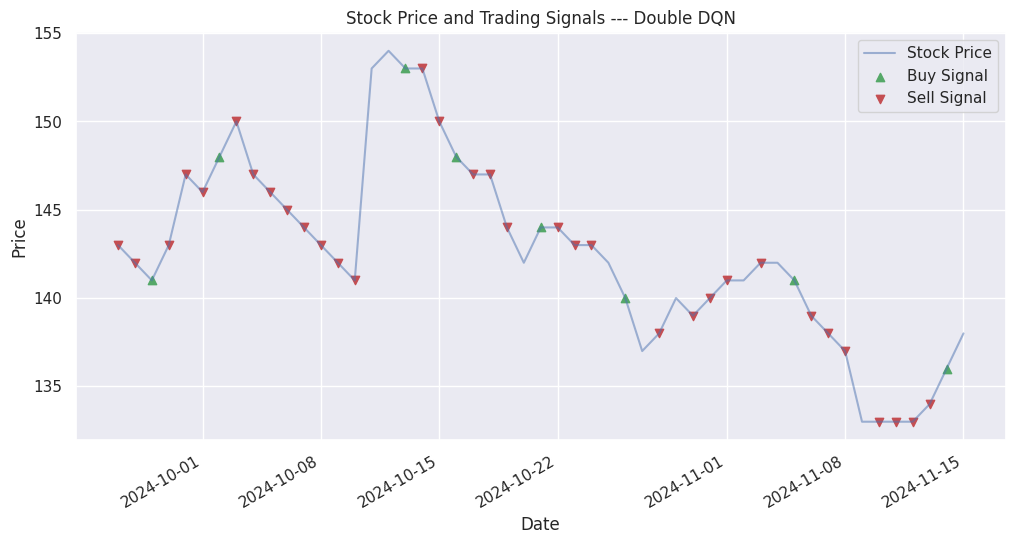

In [155]:
state_env_test = DQNState(trend=test_trend, initial_cash=initial_money, window_size=window_size)

print("\nStarting Testing...")
states_buy, states_sell, total_gains, invest = double_dqn_agent.buy(state_env=state_env_test)

print(f"\nTesting Results:")
print(f"Total Gains: ${total_gains:.2f}")
print(f"Investment Return: {invest:.2f}%")

# Plot stock prices and trading signals
plt.figure(figsize=(12, 6))
plt.plot(dates, test_trend, label="Stock Price", alpha=0.5)
plt.scatter([dates[i] for i in states_buy], [test_trend[i] for i in states_buy], marker="^", color="g", label="Buy Signal", alpha=1)
plt.scatter([dates[i] for i in states_sell], [test_trend[i] for i in states_sell], marker="v", color="r", label="Sell Signal", alpha=1)
plt.title("Stock Price and Trading Signals --- Double DQN")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()


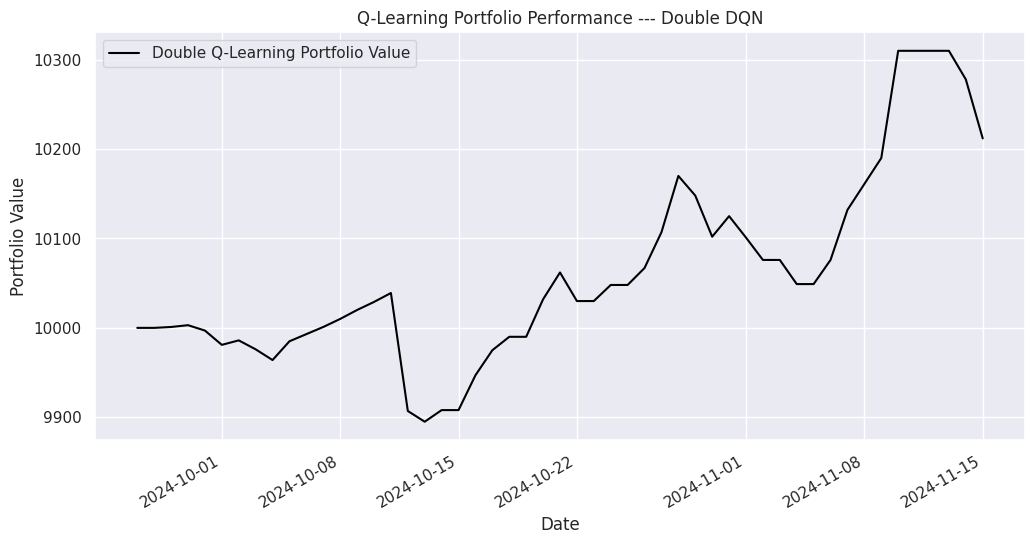

In [156]:
double_q_portfolio = [state_env_test.initial_cash]
state_env_test.reset()

for i in range(len(test_trend) - 1):
    state = state_env_test.get_state()
    action = double_dqn_agent.act(state)  # Double Q-Learning agent's act function
    next_state, _, done = state_env_test.step(action)

    # Calculate portfolio value
    current_portfolio_value = state_env_test.cash_balance + (state_env_test.stock_balance * test_trend[i])
    double_q_portfolio.append(current_portfolio_value)

    if done:
        break

# Plot Double Q-Learning portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(double_q_portfolio)], double_q_portfolio, label="Double Q-Learning Portfolio Value", color="black")
plt.title("Q-Learning Portfolio Performance --- Double DQN")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()


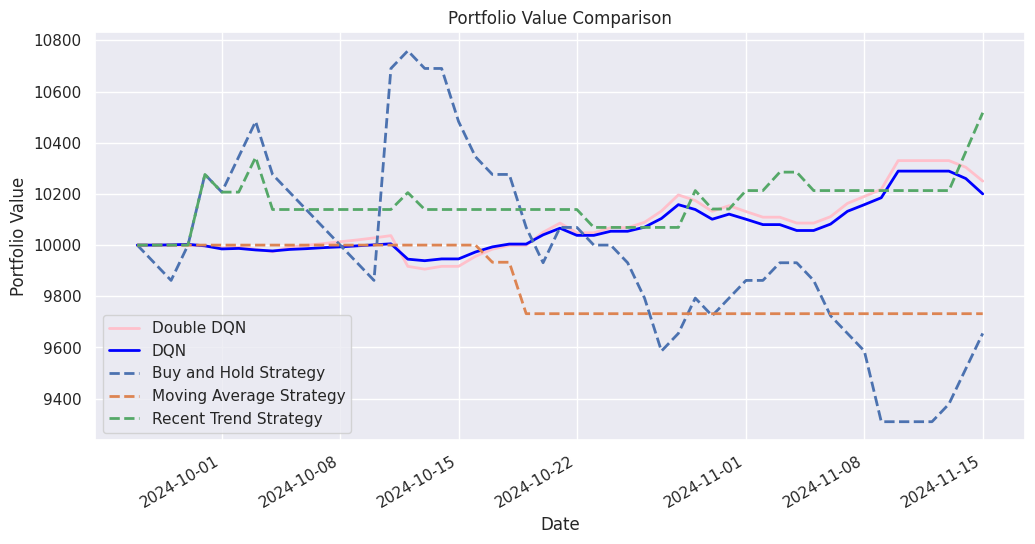


Portfolio Performance Results:
Double DQN: Total Gains = $250.00, Return = 2.50%
DQN: Total Gains = $200.00, Return = 2.00%
Buy and Hold: Total Gains = $-478.00, Return = -4.78%
Moving Average: Total Gains = $-268.00, Return = -2.68%
Recent Trend Strategy: Total Gains = $517.00, Return = 5.17%


In [139]:
initial_money = 10000

# Buy and Hold
bh_gains, bh_return = benchmark_buy_and_hold(test_trend, initial_cash=initial_money)
bh_portfolio_values = [initial_money + (initial_money // test_trend[0]) * (price - test_trend[0]) for price in test_trend]

# Moving Average
ma_gains, ma_return, ma_portfolio_values = benchmark_moving_average(test_trend, initial_cash=initial_money)

# Recent Trend Strategy
rt_gains, rt_return, rt_portfolio_values = benchmark_recent_trend_strategy(test_trend, initial_cash=initial_money)

# Double Q-Learning gains and returns
double_q_gains = double_q_portfolio[-1] - initial_money
double_q_return = (double_q_gains / initial_money) * 100

plt.figure(figsize=(12, 6))

# Plot Double Q-Learning portfolio
plt.plot(dates[:len(double_q_portfolio)], double_q_portfolio, label="Double DQN", linewidth=2, color="pink")

# Plot DQN portfolio
dqn_total_gains = dqn_portfolio[-1] - dqn_portfolio[0]
dqn_return = (dqn_portfolio[-1] / dqn_portfolio[0] - 1) * 100
plt.plot(dates[:len(dqn_portfolio)], dqn_portfolio, label="DQN", linewidth=2, color="blue")

# Plot benchmarks
plt.plot(dates, bh_portfolio_values, label="Buy and Hold Strategy", linestyle="--", linewidth=2)
plt.plot(dates, ma_portfolio_values, label="Moving Average Strategy", linestyle="--", linewidth=2)
plt.plot(dates, rt_portfolio_values, label="Recent Trend Strategy", linestyle="--", linewidth=2)

# Add labels and legend
plt.title("Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

# --- Print Results ---
print("\nPortfolio Performance Results:")
print(f"Double DQN: Total Gains = ${double_q_gains:.2f}, Return = {double_q_return:.2f}%")
print(f"DQN: Total Gains = ${dqn_total_gains:.2f}, Return = {dqn_return:.2f}%")
print(f"Buy and Hold: Total Gains = ${bh_gains:.2f}, Return = {bh_return:.2f}%")
print(f"Moving Average: Total Gains = ${ma_gains:.2f}, Return = {ma_return:.2f}%")
print(f"Recent Trend Strategy: Total Gains = ${rt_gains:.2f}, Return = {rt_return:.2f}%")


In [140]:
class DRQNState:
    def __init__(self, trend, initial_cash=10000, window_size=30):
        self.trend = trend
        self.initial_cash = initial_cash
        self.window_size = window_size
        self.state_size = (window_size, 5)  # time_steps x feature_size
        self.reset()

    def reset(self):
        self.cash_balance = self.initial_cash
        self.stock_balance = 0
        self.current_step = 0
        self.portfolio = [self.initial_cash]
        return self.get_state()

    def get_state(self):
        d = self.current_step - self.window_size + 1
        block = (
            self.trend[d : self.current_step + 1]
            if d >= 0
            else -d * [self.trend[0]] + self.trend[0 : self.current_step + 1]
        )
        price_diff = [block[i + 1] - block[i] for i in range(len(block) - 1)]
        price_diff = [0] * (self.window_size - len(price_diff)) + price_diff

        # Additional features
        cash_balance_normalized = self.cash_balance / 1e6
        stock_balance_normalized = self.stock_balance / 1e3
        current_trend = self.trend[self.current_step]
        mean_trend = np.mean(self.trend[: self.current_step + 1])

        # Construct state
        state = np.array(
            [[price_diff[i], cash_balance_normalized, stock_balance_normalized, current_trend, mean_trend]
             for i in range(self.window_size)]
        )
        return state

    def step(self, action):
        current_price = self.trend[self.current_step]

        # Apply actions
        if action == 1:  # Buy
            self.stock_balance += 1
            self.cash_balance -= current_price
        elif action == 2:  # Sell
            self.stock_balance -= 1
            self.cash_balance += current_price

        # Update portfolio value
        portfolio_value = self.cash_balance + (self.stock_balance * current_price)

        # Reward calculation
        if self.current_step > 0:
            reward = np.log(portfolio_value / self.portfolio[-1])
        else:
            reward = 0

        # Amplify reward
        reward *= 10

        # Update portfolio and step
        self.portfolio.append(portfolio_value)
        self.current_step += 1

        # Check if done
        done = self.current_step >= len(self.trend) - 1
        return (None if done else self.get_state()), reward, done


In [141]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        if next_state is None:
            next_state = np.zeros_like(state, dtype=np.float32)
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.array([e[0] for e in experiences])  # Shape: (batch_size, time_steps, feature_size)
        actions = np.array([e[1] for e in experiences], dtype=np.int32)
        rewards = np.array([e[2] for e in experiences], dtype=np.float32)
        next_states = np.array([e[3] for e in experiences])  # Same shape as states
        dones = np.array([e[4] for e in experiences], dtype=np.float32)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [142]:
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Sequential, Model


class DRQNAgent:
    def __init__(self, time_steps, feature_size, action_size=3, buffer_size=10000, batch_size=64, tau=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.time_steps = time_steps
        self.feature_size = feature_size
        self.state_size = (time_steps, feature_size)
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.tau = tau

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Q-Networks
        self.model = self._build_model()
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())

    def _build_model(self):
        model = Sequential([
            Input(shape=self.state_size),
            LSTM(256, return_sequences=True),
            LSTM(256),
            Dense(256, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
        return model

    def act(self, state):
        state = np.expand_dims(state, axis=0)  # Add batch dimension: (1, time_steps, feature_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0]) if np.random.rand() > self.epsilon else np.random.choice(self.action_size)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample()

        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        self.model.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def soft_update_target_model(self):
        target_weights = self.target_model.get_weights()
        policy_weights = self.model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * policy_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def train(self, state_env, episodes, update_every=4):
        for episode in range(episodes):
            state = state_env.reset()
            total_reward = 0
            done = False
            step = 0

            print(f"Episode {episode + 1}/{episodes} starting...")

            while not done:
                action = self.act(state)
                next_state, reward, done = state_env.step(action)
                self.memory.add(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward
                step += 1

                if step % update_every == 0:
                    self.replay()
                self.soft_update_target_model()

            print(f"Episode {episode + 1}/{episodes} completed. Total Reward: {total_reward:.2f}")

    def buy(self, state_env):
        """
        Executes the buy/sell actions using the DRQN model in a simulated environment.
        """
        state = state_env.reset()
        states_buy, states_sell = [], []

        while state_env.current_step < len(state_env.trend) - 1:
            action = self.act(state)

            # Log the action and current step for buy/sell signals
            if action == 1:  # Buy
                states_buy.append(state_env.current_step)
            elif action == 2:  # Sell
                states_sell.append(state_env.current_step)

            # Move to the next state
            state, _, done = state_env.step(action)
            if done:
                break

        # Calculate total gains and return
        total_gains = state_env.cash_balance - state_env.initial_cash
        invest = (total_gains / state_env.initial_cash) * 100
        return states_buy, states_sell, total_gains, invest




In [143]:
# Training setup
initial_money = 10000
window_size = 30
time_steps = window_size  # Time steps correspond to window_size
feature_size = 5          # Match the number of features in DRQNState.get_state()
episodes = 5

state_env_train = DRQNState(trend=train_trend, initial_cash=initial_money, window_size=window_size)

drqn_agent = DRQNAgent(
    time_steps=time_steps,
    feature_size=feature_size,
    action_size=3,  # Assume 3 actions: hold, buy, sell
    buffer_size=10000,
    batch_size=64,
    tau=0.1,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

print("Starting Training...")
drqn_agent.train(state_env=state_env_train, episodes=episodes, update_every=4)



Starting Training...
Episode 1/5 starting...
Episode 1/5 completed. Total Reward: 0.12
Episode 2/5 starting...
Episode 2/5 completed. Total Reward: 0.27
Episode 3/5 starting...
Episode 3/5 completed. Total Reward: 0.50
Episode 4/5 starting...
Episode 4/5 completed. Total Reward: 0.05
Episode 5/5 starting...
Episode 5/5 completed. Total Reward: -0.10



Testing Results:
Total Gains: $4556.00
Investment Return: 45.56%


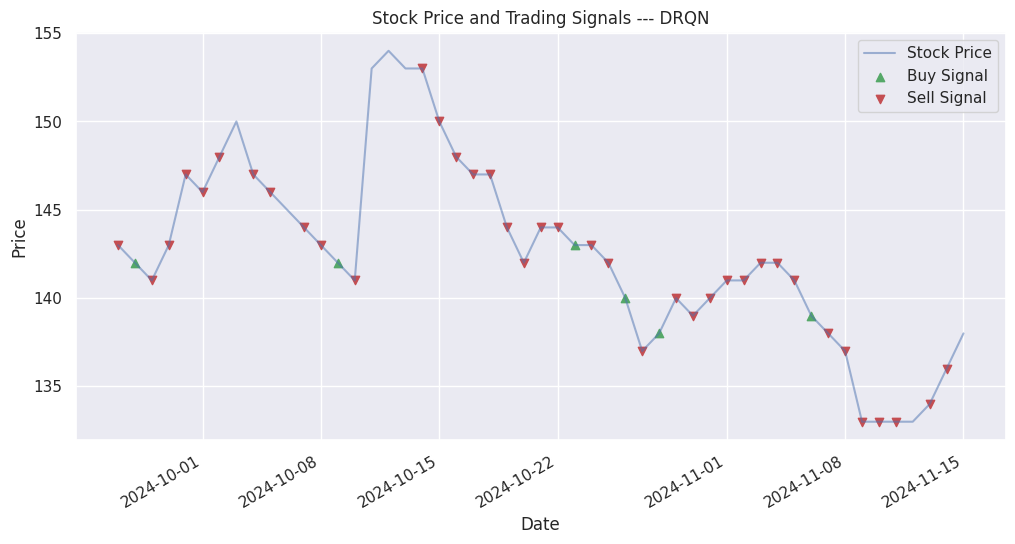

In [148]:
state_env_test = DRQNState(trend=test_trend, initial_cash=initial_money, window_size=window_size)

# Test the DRQN agent's buy/sell behavior
states_buy, states_sell, total_gains, invest = drqn_agent.buy(state_env=state_env_test)

# Results
print("\nTesting Results:")
print(f"Total Gains: ${total_gains:.2f}")
print(f"Investment Return: {invest:.2f}%")

# Visualization of buy/sell signals
plt.figure(figsize=(12, 6))
plt.plot(dates, test_trend, label="Stock Price", alpha=0.5)
plt.scatter([dates[i] for i in states_buy], [test_trend[i] for i in states_buy], marker="^", color="g", label="Buy Signal", alpha=1)
plt.scatter([dates[i] for i in states_sell], [test_trend[i] for i in states_sell], marker="v", color="r", label="Sell Signal", alpha=1)
plt.title("Stock Price and Trading Signals --- DRQN")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()


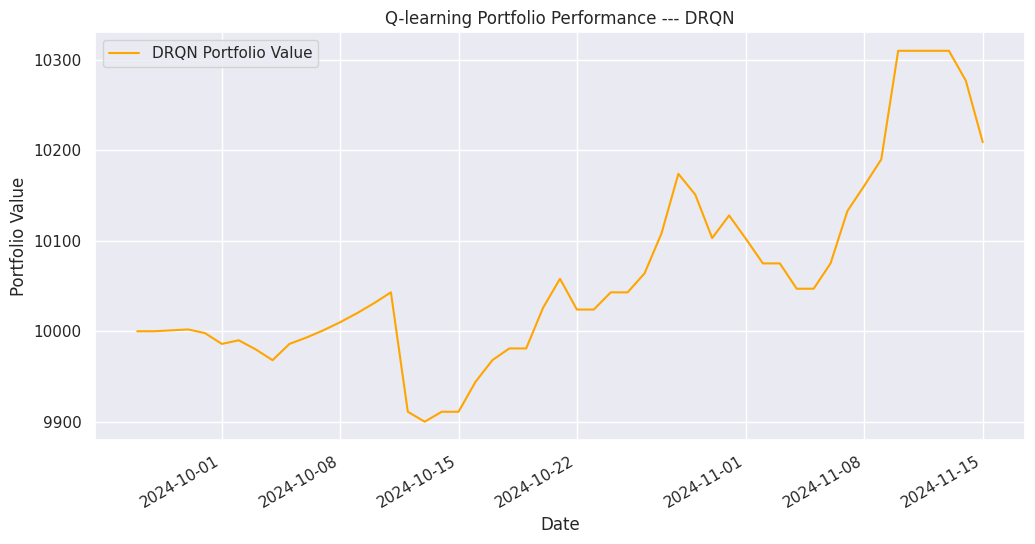

In [149]:
drqn_portfolio = [initial_money]  # Initialize portfolio values
state_env_test.reset()  # Reset the environment for testing

# Perform testing and collect DRQN portfolio values over time
for i in range(len(test_trend) - 1):
    state = state_env_test.get_state()
    action = drqn_agent.act(state)  # DRQN agent's act function
    next_state, _, done = state_env_test.step(action)

    # Calculate the current portfolio value
    current_portfolio_value = state_env_test.cash_balance + (state_env_test.stock_balance * test_trend[i])
    drqn_portfolio.append(current_portfolio_value)

    if done:
        break

# Plot portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(drqn_portfolio)], drqn_portfolio, label="DRQN Portfolio Value", color="orange")
plt.title("Q-learning Portfolio Performance --- DRQN")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()


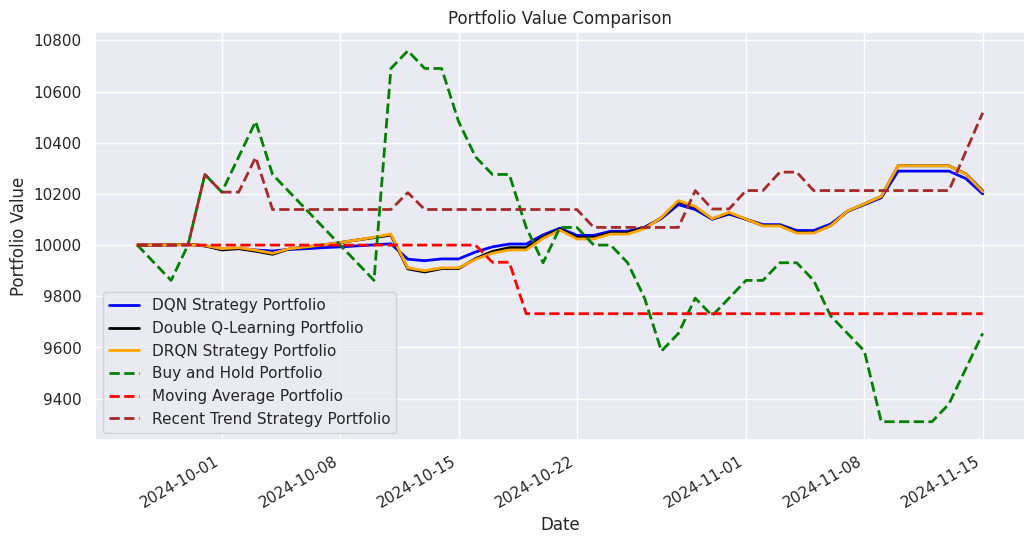

DQN: Total Gains = $200.00, Return = 2.00%
Double Q-Learning: Total Gains = $212.00, Return = 2.12%
DRQN: Total Gains = $209.00, Return = 2.09%
Buy and Hold: Total Gains = $-478.00, Return = -4.78%
Moving Average: Total Gains = $-268.00, Return = -2.68%
Recent Trend Strategy: Total Gains = $517.00, Return = 5.17%


In [157]:
# --- Calculate Benchmarks ---
initial_money = 10000

# Buy and Hold
bh_gains, bh_return = benchmark_buy_and_hold(test_trend, initial_cash=initial_money)
bh_portfolio_values = [initial_money + (initial_money // test_trend[0]) * (price - test_trend[0]) for price in test_trend]

# Moving Average
ma_gains, ma_return, ma_portfolio_values = benchmark_moving_average(test_trend, initial_cash=initial_money)

# Recent Trend Strategy
rt_gains, rt_return, rt_portfolio_values = benchmark_recent_trend_strategy(test_trend, initial_cash=initial_money)

# Double Q-Learning (calculated during testing loop)
double_q_gains = double_q_portfolio[-1] - initial_money
double_q_return = (double_q_gains / initial_money) * 100

# DQN (calculated during testing loop)
dqn_gains = dqn_portfolio[-1] - initial_money
dqn_return = (dqn_gains / initial_money) * 100

# DRQN (calculated from previous section)
drqn_gains = drqn_portfolio[-1] - initial_money
drqn_return = (drqn_gains / initial_money) * 100

# --- Portfolio Value Comparison ---
plt.figure(figsize=(12, 6))

# Plot DQN portfolio values
plt.plot(dates[:len(dqn_portfolio)], dqn_portfolio, label="DQN Strategy Portfolio", linewidth=2, color="blue")

# Plot Double Q-Learning portfolio values
plt.plot(dates[:len(double_q_portfolio)], double_q_portfolio, label="Double Q-Learning Portfolio", linewidth=2, color="black")

# Plot DRQN portfolio values
plt.plot(dates[:len(drqn_portfolio)], drqn_portfolio, label="DRQN Strategy Portfolio", linewidth=2, color="orange")

# Plot benchmarks
plt.plot(dates, bh_portfolio_values, label="Buy and Hold Portfolio", linestyle="--", linewidth=2, color="green")
plt.plot(dates, ma_portfolio_values, label="Moving Average Portfolio", linestyle="--", linewidth=2, color="red")
plt.plot(dates, rt_portfolio_values, label="Recent Trend Strategy Portfolio", linestyle="--", linewidth=2, color="brown")

# Add labels and legend
plt.title("Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

print(f"DQN: Total Gains = ${dqn_gains:.2f}, Return = {dqn_return:.2f}%")
print(f"Double Q-Learning: Total Gains = ${double_q_gains:.2f}, Return = {double_q_return:.2f}%")
print(f"DRQN: Total Gains = ${drqn_gains:.2f}, Return = {drqn_return:.2f}%")
print(f"Buy and Hold: Total Gains = ${bh_gains:.2f}, Return = {bh_return:.2f}%")
print(f"Moving Average: Total Gains = ${ma_gains:.2f}, Return = {ma_return:.2f}%")
print(f"Recent Trend Strategy: Total Gains = ${rt_gains:.2f}, Return = {rt_return:.2f}%")
